In [7]:
#Copyright 2018, Seokjun Bu, Softcomputing LAB all rights reserved.
from keras import backend as K
from keras.utils import np_utils
from keras.layers.core import Dense, Dropout, Activation, Flatten, Reshape
from keras.layers.convolutional import Convolution3D, MaxPooling3D, AveragePooling3D
from keras.layers.convolutional import Convolution2D, MaxPooling2D, AveragePooling2D
from keras.layers.convolutional import Conv2DTranspose
from keras.layers import UpSampling2D
from keras.layers import LSTM, TimeDistributed, CuDNNLSTM
from keras.layers import Input
from keras.models import Model
from keras.models import load_model
from keras.metrics import top_k_categorical_accuracy
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn import preprocessing
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import itertools
%matplotlib inline

In [8]:
# Handcrafted Function Def.
def wrapped_confusion_matrix(modelInput, feature, label, class_list=["first", "second"], normalize=False, fig_size=(5,5)):
    pred = modelInput.predict(feature)
    cnf_matrix = confusion_matrix(np.argmax(label, axis=1), np.argmax(pred, axis=1))
    np.set_printoptions(precision=2)
    plt.figure(figsize=fig_size) 
    plt.imshow(cnf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.xticks(np.arange(len(class_list)), class_list, rotation=45)
    plt.yticks(np.arange(len(class_list)), class_list)
    if(normalize):
        cnf_matrix = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
    thresh = cnf_matrix.max() / 2.
    for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        plt.text(j, i, cnf_matrix[i, j],
                 horizontalalignment='center',
                 color='white' if cnf_matrix[i, j] > thresh else 'black')
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
def plot_history(model_input, mode='loss', val_mode=True, title='Entropy'):
    history = model_input.history
    if(val_mode):
        plt.plot(history.history[mode])
        plt.plot(history.history['val_'+mode])
        plt.title(title)
        plt.legend(['train', 'test'], loc='upper right')
        plt.show()
    else:
        plt.plot(history.history[mode])
        plt.title(title)
        plt.legend(['train'], loc='upper right')
        plt.show()

In [17]:
# Load Dataset
X_train = np.load('../dataset/test/X_train.npy')
Y_train = np.load('../dataset/test/Y_train.npy')
X_test = np.load('../dataset/test/X_test.npy')
Y_test = np.load('../dataset/test/Y_test.npy')

print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(3000, 64, 64, 3) (3000, 3)
(1000, 64, 64, 3) (1000, 3)


In [36]:
model_input = Input(shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3]))
model_hidden = Convolution2D(16, kernel_size=(2, 2), padding='same', activation='relu')(model_input)
model_hidden = MaxPooling2D((2, 2))(model_hidden)
model_hidden = Convolution2D(32, kernel_size=(2, 2), padding='same', activation='relu')(model_hidden)
model_hidden = MaxPooling2D((2, 2))(model_hidden)
model_hidden = Flatten()(model_hidden)
model_hidden = Dense(1024, activation='relu')(model_hidden)
model_hidden = Dense(256, activation='relu')(model_hidden)
model_output = Dense(Y_train.shape[1], activation='softmax')(model_hidden)
model_cnn = Model(model_input, model_output)
model_cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 64, 64, 16)        208       
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 32, 32, 32)        2080      
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_19 (Dense)             (None, 1024)              8389632   
__________

In [37]:
model_cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
model_history = model_cnn.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=3, batch_size=256, verbose=2)

Train on 3000 samples, validate on 1000 samples
Epoch 1/3
 - 19s - loss: 1.6182 - acc: 0.4363 - val_loss: 0.9574 - val_acc: 0.3950
Epoch 2/3
 - 18s - loss: 0.9762 - acc: 0.4667 - val_loss: 0.9458 - val_acc: 0.5330
Epoch 3/3
 - 17s - loss: 0.9517 - acc: 0.5183 - val_loss: 0.9341 - val_acc: 0.5620


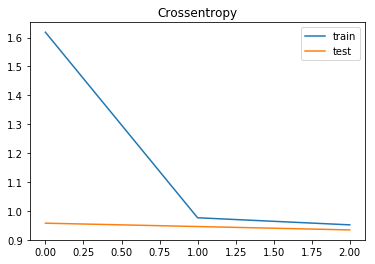

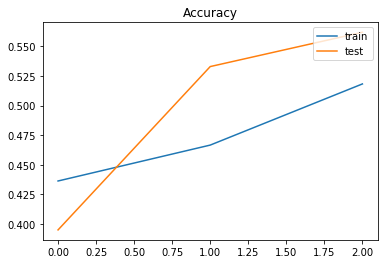

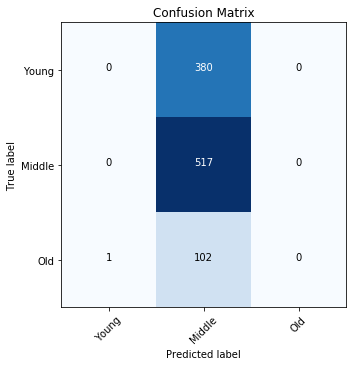

In [39]:
plot_history(model_cnn, mode='loss', title='Crossentropy')
plot_history(model_cnn, mode='acc', title='Accuracy')
class_name_list_low = ['Young', 'Middle', 'Old']
wrapped_confusion_matrix(model_lrcn, X_test, Y_test, class_list=class_name_list_low, normalize=False, fig_size=(5,5))

In [51]:
print(Y_train.shape, X_train.shape)
print(Y_test.shape, X_test.shape)

(3000, 3) (3000, 64, 64, 3)
(1000, 3) (1000, 64, 64, 3)


In [99]:
model_input = Input(shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3]))
model_hidden = Convolution2D(16, kernel_size=(2, 2), padding='same', activation='relu')(model_input)
model_hidden = MaxPooling2D((2, 2))(model_hidden)
model_hidden = Convolution2D(32, kernel_size=(2, 2), padding='same', activation='relu')(model_hidden)
model_hidden = MaxPooling2D((2, 2))(model_hidden)
model_hidden = Flatten()(model_hidden)
model_hidden = Dropout(0.5)(model_hidden)
model_hidden = Reshape((16*16*32))(model_hidden)
model_hidden = LSTM(256, return_sequences=True)(model_hidden)
model_hidden = LSTM(256, return_sequences=False)(model_hidden)
model_hidden = Dropout(0.5)(model_hidden)
model_hidden = Dense(64, activation='tanh')(model_hidden)
model_lstm = Model(model_input, model_output)
model_lstm.summary()

TypeError: 'int' object is not iterable

In [98]:
model_lstm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history_model_lstm = model_lstm.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=3, batch_size=256, verbose=2, shuffle=True)



NameError: name 'model_lstm' is not defined

In [93]:
plot_history(model_lstm, mode='loss', title='Crossentropy')
plot_history(model_lstm, mode='acc', title='Accuracy')
class_name_list_low = ['Young', 'Middle', 'Old']
wrapped_confusion_matrix(model_lstm, X_test, Y_test, class_list=class_name_list_low, normalize=False, fig_size=(5,5))

AttributeError: 'Model' object has no attribute 'history'